In [1]:
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
from traitlets import traitlets
import numpy as np
import statistics as stat
import scipy.signal as sig

%matplotlib inline

In [7]:
'''Function to generate traces from data columns in text file'''
def txt2array(filepath,usecols=(0,1,2)):
    
    #generate array from text file
    arr = np.genfromtxt(filepath,delimiter='', skip_header = 15, usecols=usecols) 
    
    #convert array from a bunch of tuples to two separate arrays
    time = arr.T[0]
    #beam_abs = arr.T[1]
    #cell_abs = arr.T[2]
    cell_abs = arr.T[1]
    yb_abs = arr.T[2]
    
    #Calculate time interval
    dt = (time[1]-time[0])*10**3 #convert s to ms
    dt = np.round(dt,decimals=5) #fix floating point errors
    
    #convert absorption dip to transmitted power
#     P_trans = DC_value + AC_cell_abs 
#     cell_OD = np.log(DC_value/P_trans)
    #Pick number of points at end to average for DC offset
    if dt == 0.001:
        num_avg = 1000
    elif dt == 0.0016:
        num_avg = 1250
    elif dt == 0.002:
        num_avg = 2000
    elif dt == 0.0009:
        num_avg = 900
    
    #offset_cell = cell_abs[:num_avg].sum()/num_avg
    offset_yb = yb_abs[:num_avg].sum()/num_avg
    offset_cell = cell_abs[2230]
    cell_OD = np.log(offset_cell/cell_abs)
    yb_OD = np.log(offset_yb)/yb_abs
    #cell_OD = subtractBackground(cell_abs,dt)
    
    
    #return [beam_signal,beam_opt_depth, cell_signal, cell_opt_depth,dt]
    return [cell_OD,yb_OD,dt]

def smooth(data,window=3):
    #window value must be odd
    
    smoothed_data=np.zeros(len(data))
    for i in range(len(data)):
        avg_val=0
        if i<(window-1)/2:
            for j in range(int(((window-1)/2))):
                index=i+j
                avg_val+=data[index]
        elif len(data)-i<(window-1)/2:
            index=i-j
            avg_val+=data[index]
        else:
            for j in range(window):
                index=i-(j+int(((window-1)/2)))
                #print(index)
                avg_val+=data[index]
        new_val=avg_val/window
        smoothed_data[i]=new_val
        
    return smoothed_data

def subtractBackground(cell_abs,dt):
    end = len(cell_abs)
    start = 5000
    t = slice(start,end)
    offset = -1.8486
    num_avg = 900
    time_ms = np.round(np.linspace(offset,dt*(end-1)+offset,end),decimals = 6)
    b_guess = cell_abs[:num_avg].sum()/num_avg
    m_guess = 0
    abs_slice = cell_abs[t]
    time_slice = time_ms[t]
    params = fitLine(time_slice,abs_slice,guess=[m_guess,b_guess])
    background = line(time_ms,*params)
    cell_OD = np.log(background/cell_abs)
    #cell_OD[cell_OD<0]=0
    return cell_OD
    
    

'''Wrapper for txt2array, makes filepath and passes it along'''
def file2array(root_folder,num,print_bool):
    
    #make file name
    num_str = str(num)
    name = 'spectra_'
    file =  name + num_str + '.txt'
    
    #path is given from current working directory
    filepath = pathlib.Path.cwd() / root_folder / file
    if print_bool:
        print(filepath)
    
#     DC_values = [7.56,7.56,
#                 8.06,8.06,
#                 7.85,7.6,
#                 7.6,7.6,
#                 7.6,7.6,
#                 8.12,8.12,
#                 8.1,8.1,
#                 7.52,7.52,
#                 8.0,8.0,
#                 8.06,8.06,
#                 7.96,7.96,
#                 7.85,7.75]
    
    return txt2array(filepath)

def transformData(OD,dt,print_bool,fig_num):
    if dt == 0.001:
        offset = -1
        t = slice(1900,7000) #5 ms
        a = t 
        abs_slice = slice(1100,3600)
    #dt = 0.002 ms
    elif dt == 0.0016:
        offset = -4
        t = slice(3125,7500) #5 ms
        a = t
        abs_slice = slice(2500,5000)
    elif dt == 0.002:
        offset = -2.5 #ms
        t = slice(1500,6500)
        a = t
        abs_slice = slice(1250,2750)
    elif dt == 0.0008:
        offset = -1.1544
        t = slice(1443,4000)
    elif dt==0.0018:
        offset = -1.8486
        t = slice(1125,2000)
    elif dt == 0.0009:
        offset = -1.9998
        t = slice(2225,4500)
    OD_smooth=smooth(OD,window=15)
    time_ms = np.round(np.linspace(offset,dt*(len(OD)-1)+offset,len(OD)),decimals = 6)
    integrated = np.round(OD_smooth[t].sum()*dt,decimals=6)
    if True:
        plt.figure(fig_num)
        plt.plot(time_ms[t],OD_smooth[t])
    return integrated
                       
def gaussian(x,a,b,n,c):
    value= n*np.exp(-(x-b)**2/(2*a**2))+c
    return value

def line(x,m,b):
    value = m*x+b
    return value

def fitLine(xscale, data,guess=[0,0]):
    try:
        popt,pcov = curve_fit(line,xscale,data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    #print('Slope = {}'.format(popt[0]))
    return popt

def twoGaussians(x,a1,a2,b1,b2,n1,n2,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)
    return total

def threeGaussians(x,a1,a2,a3,b1,b2,b3,n1,n2,n3,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    params3 = [a3,b3,n3,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)+gaussian(x,*params3)
    return total
    
def fitGaussian(xscale, data,guess=[100,0,0.16,0],sigma=None):
    try:
        popt, pcov = curve_fit(gaussian, xscale, data,p0=guess,sigma=sigma,bounds=([20.0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,0.01]))
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    print('Standard Dev = ',popt[0])
    print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n\n')
    print('Mean = {} +/- {} MHz, StDev = {} +/- {} MHz'.format(popt[1],perr[1],popt[0],perr[0]))
    return popt

def gen_spectra(w):
        print('Generating spectra from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,print_w.value)
        w.value = results
        print('Done')
        
def fit3Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(threeGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(3):
        peaknum = i+1
        mean = popt[3+i]
        mean_err = perr[3+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

def fit2Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(twoGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(2):
        peaknum = i+1
        mean = popt[2+i]
        mean_err = perr[2+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
        

def processData(folder_path,start_num,stop_num,print_bool):
    stop_num+=1
    blocked_OD_YbOH = []
    unblocked_OD_YbOH = []
    enhancement_YbOH=[]
    
    blocked_OD_Yb = []
    unblocked_OD_Yb = []
    enhancement_Yb = []
    
    #Freq is given as 539386xxx
    freq_556 = [
        6550.0,
        6340.0,
        6670.0,
        7100.0,
        6820.0,
        7370.0,
        7710.0,
        7530.0,
        7260.0,
        6880.0,
        6740.0,
        6215.0,
        5800.0,
        5586.0,
        5300.0,
        5030.0,
        5575.0,
        5940.0,
        6200.0,
        6310.0,
        6410.0,
        6615.0,
        6675.0,
        6570.0,
        6820.0,
        6945.0,
        6715.0
    ]
    
    B_or_uB = 'uB'
    plt.figure(1)
    plt.title('Blocked 556 YbOH OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked 556 YbOH OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked 556 Yb OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked 556 Yb OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for i in range(start_num,stop_num):
#         if i==157 or i==190:
#             pass
#         elif B_or_uB == 'B':
        if B_or_uB == 'B':
            OD_YbOH,OD_Yb,dt = file2array(folder_path,i,print_bool)
            if print_bool:
                print('Blocked')
            integrated1= transformData(OD_YbOH,dt,print_bool,fig_num=1)
            blocked_OD_YbOH.append(integrated1)
            integrated2= transformData(OD_Yb,dt,print_bool,fig_num=3)
            blocked_OD_Yb.append(integrated2)
            B_or_uB = 'uB'
        elif B_or_uB == 'uB':
            OD_YbOH,OD_Yb,dt = file2array(folder_path,i,print_bool)
            if print_bool:
                print('Unblocked')
            integrated1 = transformData(OD_YbOH,dt,print_bool,fig_num=2)
            unblocked_OD_YbOH.append(integrated1)
            integrated2 = transformData(OD_Yb,dt,print_bool,fig_num=4)
            unblocked_OD_Yb.append(integrated2)
            B_or_uB = 'B'
        progress.value = float(i-start_num+1)/(stop_num-start_num)
    
    for l in range(len(blocked_OD_YbOH)):
        ratio_YbOH=unblocked_OD_YbOH[l]/blocked_OD_YbOH[l]
        ratio_Yb=unblocked_OD_Yb[l]/blocked_OD_Yb[l]
        #if ratio<0:
        #    ratio=0
        enhancement_YbOH.append(ratio_YbOH)
        enhancement_Yb.append(ratio_Yb)
    
#     num_avg=3
#     for j in range(int(len(enhancement)/num_avg)):
#         avg_values=[]
#         for k in range(int(num_avg)):
#             avg_values.append(enhancement[(j*int(num_avg))+(k)])
#         if len(avg_values)!= num_avg:
#             print('error')
#         avg_enhancement.append(stat.mean(avg_values))
#         avg_enhancement_err.append(stat.stdev(avg_values))
    
#     freq_all=[]
#     for i in range(len(freq_556)):
#         for j in range(3):
#             freq_all.append(freq_556[i])
    
    enhancement_YbOH_sorted = [OD for freq,OD in sorted(zip(freq_556,enhancement_YbOH))]
    enhancement_Yb_sorted = [OD for freq,OD in sorted(zip(freq_556,enhancement_Yb))]
    #     blocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,blocked_OD))]
#     unblocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,unblocked_OD))]
    freq_556_sorted = sorted(freq_556)
    return [freq_556_sorted,enhancement_YbOH_sorted, enhancement_Yb_sorted]



A Jupyter Widget

Generating spectra from  20181213


A Jupyter Widget

Done


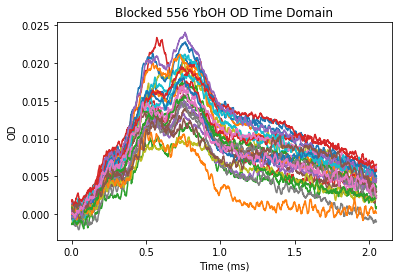

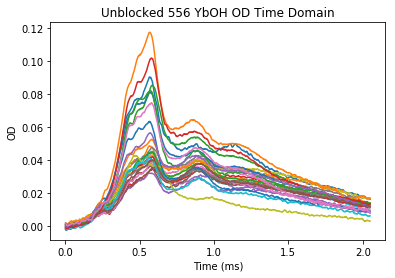

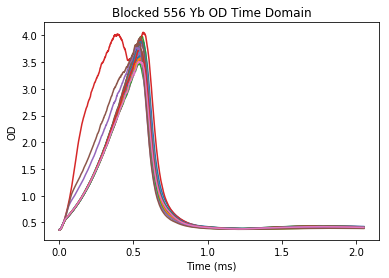

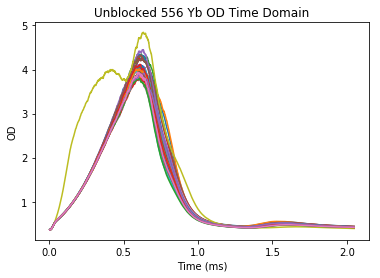

In [8]:
style = {'description_width': 'initial'}

folder_path_w = widgets.Text(
    value='20181213',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=68,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=121,
    description='Ending File',
    disabled=False,
    style=style
)
start_setpnt_w = widgets.FloatText(
    value=0.07,
    description='Starting Set Point',
    disabled=False,
    style=style
)
stop_setpnt_w = widgets.FloatText(
    value=-0.13,
    description='Ending Set Point',
    disabled=False,
    style=style
)
setpnt_int_w = widgets.FloatText(
    value=-0.04,
    description='Set Point Step Size',
    disabled=False,
    style=style
)
print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)

go_button = widgets.Button(
    description='Generate Spectra',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

num_data_pnts_w = widgets.FloatText(
    value=7,
    description='Number of data points in spectra',
    disabled=False,
    style=style
)

num_spectra_w = widgets.FloatText(
    value=5,
    description= 'Number of spectra',
    disabled=False,
    style=style
)
lb = LoadedButton(description="Generate Spectra", value=[])
lb.on_click(gen_spectra)
row0=folder_path_w
r0=widgets.HBox([row0])
row1=[start_num_w,stop_num_w]
r1 = widgets.HBox(row1)
# row2=[start_setpnt_w,stop_setpnt_w,setpnt_int_w]
# r2 = widgets.HBox(row2)
# row3=[num_data_pnts_w,num_spectra_w]
# r3=widgets.HBox(row3)
r4 = widgets.HBox([lb,print_w])
widgets.VBox([r0,r1,r4])


In [10]:
all_data1 = lb.value

In [11]:
freq_556_1=all_data1[0]
enhancement_YbOH_1=all_data1[1]
enhancement_Yb_1=all_data1[2]

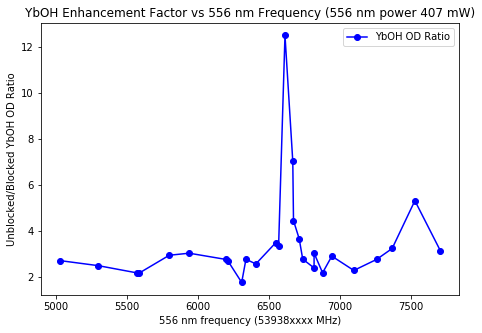

In [15]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_1,enhancement_YbOH_1,'bo-',label='YbOH OD Ratio')
plt.title('YbOH Enhancement Factor vs 556 nm Frequency (556 nm power 407 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked YbOH OD Ratio')
plt.legend(loc='best');

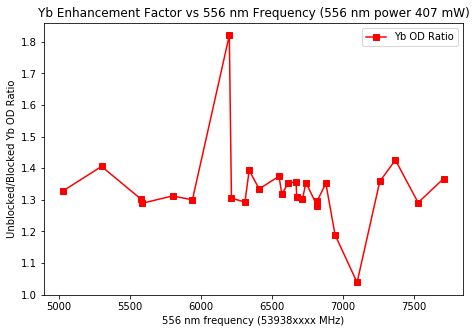

In [16]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_1,enhancement_Yb_1,'rs-',label='Yb OD Ratio')
plt.title('Yb Enhancement Factor vs 556 nm Frequency (556 nm power 407 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked Yb OD Ratio')
plt.legend(loc='best');

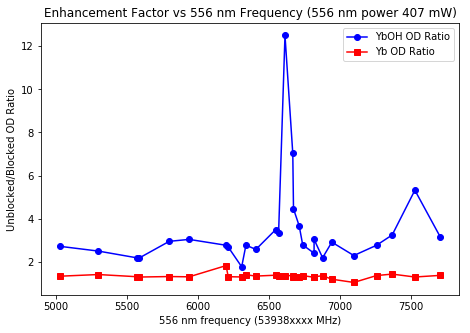

In [17]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_1,enhancement_YbOH_1,'bo-',label='YbOH OD Ratio')
plt.plot(freq_556_1,enhancement_Yb_1,'rs-',label='Yb OD Ratio')
plt.title('Enhancement Factor vs 556 nm Frequency (556 nm power 407 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked OD Ratio')
plt.legend(loc='best');

In [18]:
def processData2(folder_path,start_num,stop_num,print_bool):
    stop_num+=1
    blocked_OD_YbOH = []
    unblocked_OD_YbOH = []
    enhancement_YbOH=[]
    
    blocked_OD_Yb = []
    unblocked_OD_Yb = []
    enhancement_Yb = []
    
    #Freq is given as 539386xxx
    freq_556 = [
        6520.0,
        6600.0,
        6710.0,
        6855.0,
        7250.0,
        7410.0,
        7200.0,
        6990.0,
        6275.0,
        6005.0,
        5855.0,
        5680.0,
        5925.0,
        6200.0,
        6280.0,
        6360.0,
        6450.0,
        6500.0,
        6560.0,
        6870.0
    ]
    
    B_or_uB = 'uB'
    plt.figure(1)
    plt.title('Blocked 556 YbOH OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked 556 YbOH OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked 556 Yb OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked 556 Yb OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for i in range(start_num,stop_num):
#         if i==157 or i==190:
#             pass
#         elif B_or_uB == 'B':
        if B_or_uB == 'B':
            OD_YbOH,OD_Yb,dt = file2array(folder_path,i,print_bool)
            if print_bool:
                print('Blocked')
            integrated1= transformData(OD_YbOH,dt,print_bool,fig_num=1)
            blocked_OD_YbOH.append(integrated1)
            integrated2= transformData(OD_Yb,dt,print_bool,fig_num=3)
            blocked_OD_Yb.append(integrated2)
            B_or_uB = 'uB'
        elif B_or_uB == 'uB':
            OD_YbOH,OD_Yb,dt = file2array(folder_path,i,print_bool)
            if print_bool:
                print('Unblocked')
            integrated1 = transformData(OD_YbOH,dt,print_bool,fig_num=2)
            unblocked_OD_YbOH.append(integrated1)
            integrated2 = transformData(OD_Yb,dt,print_bool,fig_num=4)
            unblocked_OD_Yb.append(integrated2)
            B_or_uB = 'B'
        progress.value = float(i-start_num+1)/(stop_num-start_num)
    
    for l in range(len(blocked_OD_YbOH)):
        ratio_YbOH=unblocked_OD_YbOH[l]/blocked_OD_YbOH[l]
        ratio_Yb=unblocked_OD_Yb[l]/blocked_OD_Yb[l]
        #if ratio<0:
        #    ratio=0
        enhancement_YbOH.append(ratio_YbOH)
        enhancement_Yb.append(ratio_Yb)
    
#     num_avg=3
#     for j in range(int(len(enhancement)/num_avg)):
#         avg_values=[]
#         for k in range(int(num_avg)):
#             avg_values.append(enhancement[(j*int(num_avg))+(k)])
#         if len(avg_values)!= num_avg:
#             print('error')
#         avg_enhancement.append(stat.mean(avg_values))
#         avg_enhancement_err.append(stat.stdev(avg_values))
    
#     freq_all=[]
#     for i in range(len(freq_556)):
#         for j in range(3):
#             freq_all.append(freq_556[i])
    
    enhancement_YbOH_sorted = [OD for freq,OD in sorted(zip(freq_556,enhancement_YbOH))]
    enhancement_Yb_sorted = [OD for freq,OD in sorted(zip(freq_556,enhancement_Yb))]
    #     blocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,blocked_OD))]
#     unblocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,unblocked_OD))]
    freq_556_sorted = sorted(freq_556)
    return [freq_556_sorted,enhancement_YbOH_sorted, enhancement_Yb_sorted]

def gen_spectra2(w):
        print('Generating spectra from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = processData2(folder_path_w.value,start_num_w.value,stop_num_w.value,print_w.value)
        w.value = results
        print('Done')
        


A Jupyter Widget

Generating spectra from  20181213


A Jupyter Widget

Done


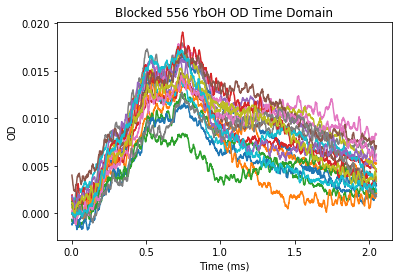

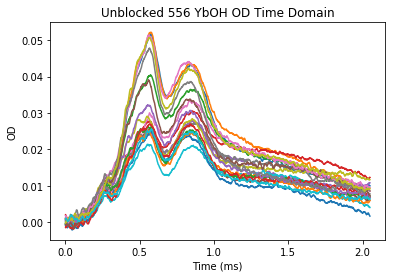

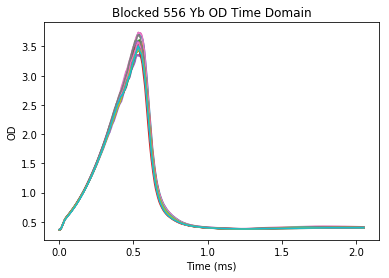

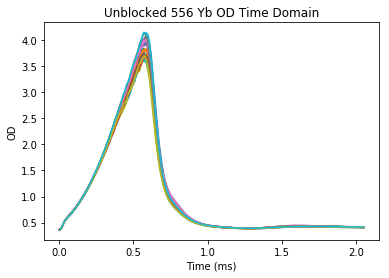

In [19]:
style = {'description_width': 'initial'}

folder_path_w = widgets.Text(
    value='20181213',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=122,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=161,
    description='Ending File',
    disabled=False,
    style=style
)
start_setpnt_w = widgets.FloatText(
    value=0.07,
    description='Starting Set Point',
    disabled=False,
    style=style
)
stop_setpnt_w = widgets.FloatText(
    value=-0.13,
    description='Ending Set Point',
    disabled=False,
    style=style
)
setpnt_int_w = widgets.FloatText(
    value=-0.04,
    description='Set Point Step Size',
    disabled=False,
    style=style
)
print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)

go_button = widgets.Button(
    description='Generate Spectra',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

num_data_pnts_w = widgets.FloatText(
    value=7,
    description='Number of data points in spectra',
    disabled=False,
    style=style
)

num_spectra_w = widgets.FloatText(
    value=5,
    description= 'Number of spectra',
    disabled=False,
    style=style
)
lb = LoadedButton(description="Generate Spectra", value=[])
lb.on_click(gen_spectra2)
row0=folder_path_w
r0=widgets.HBox([row0])
row1=[start_num_w,stop_num_w]
r1 = widgets.HBox(row1)
# row2=[start_setpnt_w,stop_setpnt_w,setpnt_int_w]
# r2 = widgets.HBox(row2)
# row3=[num_data_pnts_w,num_spectra_w]
# r3=widgets.HBox(row3)
r4 = widgets.HBox([lb,print_w])
widgets.VBox([r0,r1,r4])


In [20]:
all_data2 = lb.value

In [21]:
freq_556_2=all_data2[0]
enhancement_YbOH_2=all_data2[1]
enhancement_Yb_2=all_data2[2]

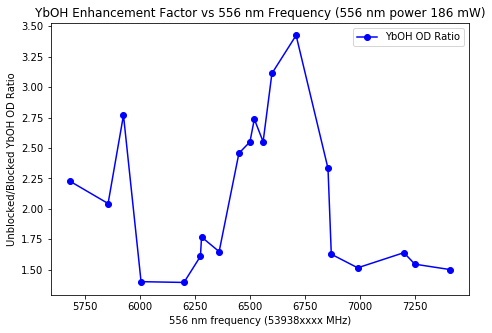

In [22]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_2,enhancement_YbOH_2,'bo-',label='YbOH OD Ratio')
plt.title('YbOH Enhancement Factor vs 556 nm Frequency (556 nm power 186 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked YbOH OD Ratio')
plt.legend(loc='best');

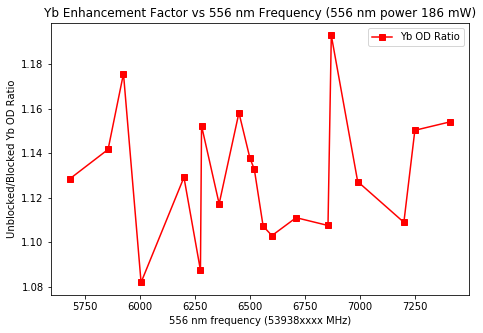

In [23]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_2,enhancement_Yb_2,'rs-',label='Yb OD Ratio')
plt.title('Yb Enhancement Factor vs 556 nm Frequency (556 nm power 186 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked Yb OD Ratio')
plt.legend(loc='best');

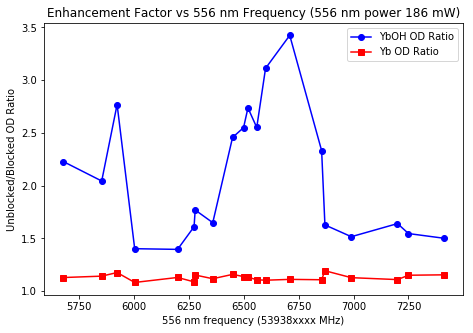

In [24]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_2,enhancement_YbOH_2,'bo-',label='YbOH OD Ratio')
plt.plot(freq_556_2,enhancement_Yb_2,'rs-',label='Yb OD Ratio')
plt.title('Enhancement Factor vs 556 nm Frequency (556 nm power 186 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked OD Ratio')
plt.legend(loc='best');

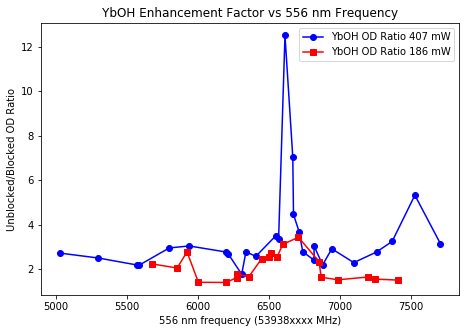

In [26]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_1,enhancement_YbOH_1,'bo-',label='YbOH OD Ratio 407 mW')
plt.plot(freq_556_2,enhancement_YbOH_2,'rs-',label='YbOH OD Ratio 186 mW')
plt.title('YbOH Enhancement Factor vs 556 nm Frequency')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked OD Ratio')
plt.legend(loc='best');

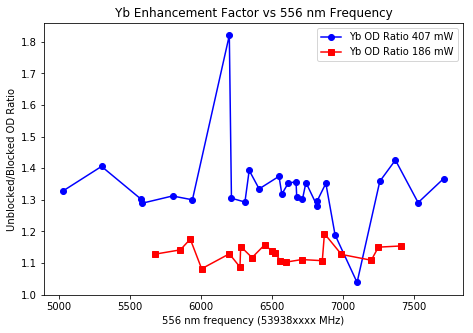

In [27]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556_1,enhancement_Yb_1,'bo-',label='Yb OD Ratio 407 mW')
plt.plot(freq_556_2,enhancement_Yb_2,'rs-',label='Yb OD Ratio 186 mW')
plt.title('Yb Enhancement Factor vs 556 nm Frequency')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked OD Ratio')
plt.legend(loc='best');